In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import numpy.linalg as npLA

In [2]:
def make_parametric_system(n=30, m=1, q=1, seed=0):
    rng = np.random.default_rng(seed)

    # stabilna A0 - negativno dominantna dijagonala 
    diag = -np.linspace(1.0, 3.0, n)
    A0 = np.diag(diag)
    A0 += 0.05 * rng.standard_normal((n, n))

    A1 = 0.2 * rng.standard_normal((n, n))
    A2 = 0.2 * rng.standard_normal((n, n))

    B = rng.standard_normal((n, m))
    C = rng.standard_normal((q, n))

    # skaliranje matrica da ne naruse stabilnost sustava
    A1 = (A1 - A1.T) * 0.05 + (A1 + A1.T) * 0.02
    A2 = (A2 - A2.T) * 0.05 + (A2 + A2.T) * 0.02

    return A0, A1, A2, B, C

A0, A1, A2, B, C = make_parametric_system(n=30, seed=1)

def A_of_p(p1, p2):
    return A0 + p1*A1 + p2*A2


In [3]:
p1_vals = np.linspace(-1.0, 1.0, 11)
p2_vals = np.linspace(-1.0, 1.0, 11)
param_grid = [(p1, p2) for p1 in p1_vals for p2 in p2_vals]


In [4]:
def is_stable(A, tol=1e-8):
    lam = la.eigvals(A)
    return np.max(np.real(lam)) < -tol

stable_flags = [is_stable(A_of_p(p1,p2)) for (p1,p2) in param_grid]
print("Stabilno na mreži:", all(stable_flags), f"({sum(stable_flags)}/{len(stable_flags)})")


Stabilno na mreži: True (121/121)


In [5]:
def gramian_controllability(A, B):
    return la.solve_continuous_lyapunov(A, -(B @ B.T))

def h2_norm(A, B, C):
    if np.max(np.real(la.eigvals(A))) >= 0:
        return np.inf
    P = la.solve_continuous_lyapunov(A, -(B @ B.T))
    val2 = np.real(np.trace(C @ P @ C.T))
    return float(np.sqrt(max(val2, 0.0)))

def h2_error(full, red):
    Af, Bf, Cf = full
    Ar, Br, Cr = red

    # G - Gr
    # x_e = [x; xr]
    Ae = la.block_diag(Af, Ar)
    Be = np.vstack([Bf, Br])
    Ce = np.hstack([Cf, -Cr])

    return h2_norm(Ae, Be, Ce)


In [ ]:
def balanced_truncation_basis(A, B, C, r):
    # gramijani
    P = gramian_controllability(A, B)
    Q = la.solve_continuous_lyapunov(A.T, -(C.T @ C))

    # Cholesky
    eps = 1e-10
    P = (P + P.T) / 2
    Q = (Q + Q.T) / 2

    # stabiliziram ako treba
    P_reg = P + eps*np.eye(P.shape[0])
    Q_reg = Q + eps*np.eye(Q.shape[0])

    R = la.cholesky(P_reg, lower=True)
    S = la.cholesky(Q_reg, lower=True)

    M = S.T @ R
    U, s, Vt = la.svd(M, full_matrices=False)
    
    # plotam HSV
    plt.semilogy(s, 'r.')
    plt.show()
    print(s)

    # r dominantnih sv
    Ur = U[:, :r]
    Vr = Vt.T[:, :r]
    sr = s[:r]

    # projekcijske baze
    Sigma_inv_sqrt = np.diag(1.0 / np.sqrt(sr))
    V = R @ Vr @ Sigma_inv_sqrt
    W = S @ Ur @ Sigma_inv_sqrt

    # biortogonalizacija proj baza da W.T @ V = I
    Mwv = W.T @ V
    U2, s2, Vt2 = la.svd(Mwv)
    V = V @ (Vt2.T @ np.diag(1.0/np.sqrt(s2)) @ U2.T)
    W = W @ (U2 @ np.diag(1.0/np.sqrt(s2)) @ Vt2)
    return V, W, s  # s = sve Hankel singularne vrijednosti


In [7]:
## Provjera 

def bt_diag(A, B, C, r, eps=1e-10):

    P = la.solve_continuous_lyapunov(A, -(B @ B.T))
    Q = la.solve_continuous_lyapunov(A.T, -(C.T @ C))

    P = 0.5*(P + P.T)
    Q = 0.5*(Q + Q.T)

    P += eps*np.eye(P.shape[0])
    Q += eps*np.eye(Q.shape[0])

    print("Matrica P iznosi:\n", P)
    print("\nMatrica Q iznosi:\n", Q)

    R = la.cholesky(P, lower=True)
    S = la.cholesky(Q, lower=True)

    M = S.T @ R
    U, sigma, Vt = la.svd(M, full_matrices=False)

    Sigma_inv_sqrt = np.diag(1.0 / np.sqrt(sigma))
    T = R @ Vt.T @ Sigma_inv_sqrt
    T_inv = Sigma_inv_sqrt @ U.T @ S.T

    A_t = T_inv @ A @ T
    B_t = T_inv @ B
    C_t = C @ T

    A_r = A_t[:r, :r]
    B_r = B_t[:r, :]
    C_r = C_t[:, :r]
    D_r = np.zeros((C.shape[0], B.shape[1]))

    print("\nA_r iznosi:\n", A_r)
    print("\nB_r iznosi:\n", B_r)
    print("\nC_r iznosi:\n", C_r)
    print("\nD_r iznosi:\n", D_r)

    P_bal = la.solve_continuous_lyapunov(A_r, -(B_r @ B_r.T))
    Q_bal = la.solve_continuous_lyapunov(A_r.T, -(C_r.T @ C_r))

    P_bal = 0.5*(P_bal + P_bal.T)
    Q_bal = 0.5*(Q_bal + Q_bal.T)

    print("\nGramijan upravljivosti reduciranog sustava:\n", P_bal)
    print("\nGramijan osmotrivosti reduciranog sustava:\n", Q_bal)

    print(f"Ocjena pogreske: {2*sum(sigma[r:])}")

    print("||Pb - Qb||_F =", la.norm(P_bal - Q_bal, 'fro'))

    return A_r, B_r, C_r, sigma


In [8]:
p_test = (0.0, 0.0)
A_test = A_of_p(*p_test)

bt_diag(A_test, B, C, r=3)


Matrica P iznosi:
 [[ 8.85873344e-02  7.48005306e-02 -1.14709891e-02  1.06675173e-01
   1.29915410e-01 -1.04089479e-01  8.25881073e-02  3.23839893e-01
  -1.67049692e-01 -4.34469106e-02 -9.72427212e-02  3.30283613e-01
  -2.24618171e-01 -8.99664407e-03  1.13739017e-01 -1.19727284e-01
  -1.29633984e-02 -8.15574033e-02 -1.70714876e-01 -1.85012494e-02
   3.14356384e-02 -4.00347106e-02  1.79960861e-02  8.30052470e-02
   1.24828949e-01 -1.36769476e-01  6.67352687e-02 -5.04452134e-02
  -1.98499828e-01 -8.12017216e-02]
 [ 7.48005306e-02  6.42281805e-02 -1.05799157e-02  9.01163749e-02
   1.10194256e-01 -9.01027922e-02  6.98512698e-02  2.83812877e-01
  -1.47612654e-01 -3.91225966e-02 -8.76611591e-02  2.90241419e-01
  -1.98180745e-01 -7.66687076e-03  1.02647122e-01 -1.07062623e-01
  -1.26113075e-02 -7.40479813e-02 -1.53541965e-01 -1.60614701e-02
   3.04546282e-02 -3.67926874e-02  1.65359637e-02  7.48383027e-02
   1.14024700e-01 -1.23952806e-01  6.06403136e-02 -4.69914873e-02
  -1.80855574e-01 -7.3

(array([[-1.36986374, -0.16148602,  0.20660073],
        [-0.16148602, -0.47982187,  1.50240606],
        [-0.20660074, -1.50240613, -3.98125516]]),
 array([[-2.50226568],
        [-0.14898212],
        [-0.18832616]]),
 array([[-2.50226568, -0.14898212,  0.18832616]]),
 array([2.28538554e+00, 2.31290781e-02, 4.45421724e-03, 1.72595850e-05,
        1.98261169e-07, 1.62298129e-08, 3.34040797e-09, 2.74282330e-09,
        5.18555549e-10, 3.13791611e-10, 2.64250528e-10, 2.18834367e-10,
        1.30379600e-10, 1.15951729e-10, 1.08682255e-10, 1.02645048e-10,
        1.00231398e-10, 1.00040522e-10, 1.00004022e-10, 1.00000550e-10,
        1.00000253e-10, 1.00000071e-10, 1.00000055e-10, 1.00000034e-10,
        1.00000030e-10, 1.00000020e-10, 9.99999763e-11, 9.99999728e-11,
        9.99998972e-11, 9.99997860e-11]))

In [9]:
def merge_V_bases(V_list, r_merge=None):
    Vcat = np.hstack(V_list)
    V, _ = la.qr(Vcat, mode='economic')   
    if r_merge is not None:
        V = V[:, :r_merge]
    return V


In [10]:
def project_model_galerkin(A, B, C, V):
    Ar = V.T @ A @ V
    Br = V.T @ B
    Cr = C @ V
    return Ar, Br, Cr


In [11]:
def greedy_parametric_bt(
    param_grid, A_of_p, B, C,
    r_loc=4, K=8, tol=1e-2,
    p_start=(0.0, 0.0),
    r_merge_cap=None
):
    selected_params = []
    V_list = []
    max_errors = []
    argmax_params = []

    # start
    selected_params.append(p_start)
    A = A_of_p(*p_start)
    V0, _, _ = balanced_truncation_basis(A, B, C, r=r_loc) 
    V_list.append(V0)

    for k in range(K):
        # merge
        V = merge_V_bases(V_list, r_merge=r_merge_cap)

        # evaluacija na mreži
        errors = []
        for (p1,p2) in param_grid:
            Af = A_of_p(p1,p2)
            full = (Af, B, C)

            Ar, Br, Cr = project_model_galerkin(Af, B, C, V)
            red = (Ar, Br, Cr)

            e = h2_error(full, red)
            errors.append(e)

        errors = np.array(errors)
        idx = int(np.argmax(errors))
        emax = float(errors[idx])
        p_worst = param_grid[idx]

        max_errors.append(emax)
        argmax_params.append(p_worst)

        print(f"iter {k+1:02d}: dim(V)={V.shape[1]:2d}  max H2 error={emax:.4e} at p={p_worst}")

        if emax < tol:
            break

        # dodaj novu greedy točku
        selected_params.append(p_worst)
        Anew = A_of_p(*p_worst)
        Vn, _, _ = balanced_truncation_basis(Anew, B, C, r=r_loc)
        V_list.append(Vn); 
    

    return {
        "selected_params": selected_params,
        "V_list": V_list,
        "max_errors": max_errors,
        "argmax_params": argmax_params
    }


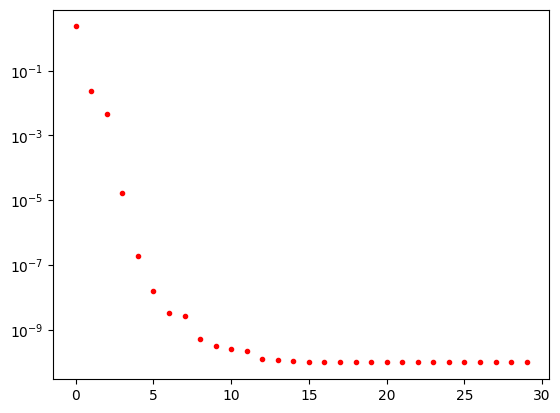

[2.28538554e+00 2.31290781e-02 4.45421724e-03 1.72595850e-05
 1.98261169e-07 1.62298129e-08 3.34040797e-09 2.74282330e-09
 5.18555549e-10 3.13791611e-10 2.64250528e-10 2.18834367e-10
 1.30379600e-10 1.15951729e-10 1.08682255e-10 1.02645048e-10
 1.00231398e-10 1.00040522e-10 1.00004022e-10 1.00000550e-10
 1.00000253e-10 1.00000071e-10 1.00000055e-10 1.00000034e-10
 1.00000030e-10 1.00000020e-10 9.99999763e-11 9.99999728e-11
 9.99998972e-11 9.99997860e-11]
iter 01: dim(V)= 3  max H2 error=5.8907e-02 at p=(-1.0, -1.0)


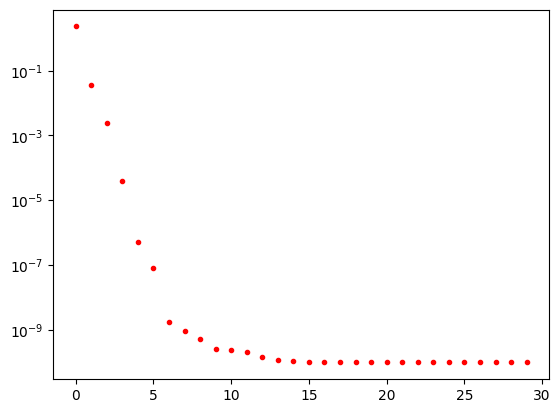

[2.28171752e+00 3.60284050e-02 2.38296723e-03 3.93771270e-05
 5.06874250e-07 8.07203368e-08 1.81245334e-09 9.25896568e-10
 5.19635125e-10 2.52878439e-10 2.38780844e-10 2.08657782e-10
 1.49300937e-10 1.17415345e-10 1.07690126e-10 1.03764788e-10
 1.00341357e-10 1.00056523e-10 1.00009623e-10 1.00000725e-10
 1.00000143e-10 1.00000122e-10 1.00000056e-10 1.00000037e-10
 1.00000014e-10 1.00000010e-10 1.00000008e-10 9.99999746e-11
 9.99999419e-11 9.99997928e-11]
iter 02: dim(V)= 6  max H2 error=5.5024e-02 at p=(-1.0, 1.0)


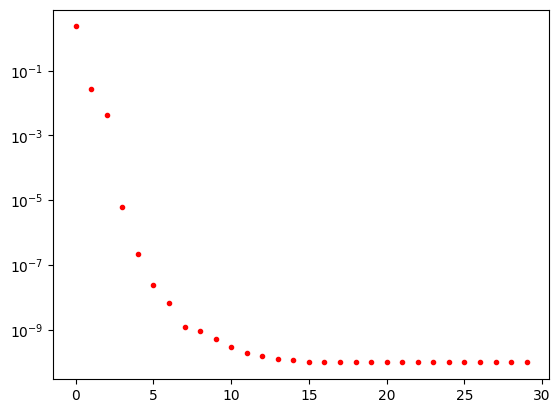

[2.28376327e+00 2.77891175e-02 4.11949671e-03 6.00322905e-06
 2.23173814e-07 2.39548494e-08 6.78354573e-09 1.20883292e-09
 9.39866896e-10 5.24511598e-10 3.10584869e-10 2.00049607e-10
 1.54436160e-10 1.23743157e-10 1.20424388e-10 1.04051089e-10
 1.00414521e-10 1.00071115e-10 1.00007264e-10 1.00000953e-10
 1.00000257e-10 1.00000114e-10 1.00000055e-10 1.00000050e-10
 1.00000041e-10 1.00000013e-10 9.99999754e-11 9.99999098e-11
 9.99999054e-11 9.99998717e-11]
iter 03: dim(V)= 9  max H2 error=1.1556e-02 at p=(1.0, 1.0)


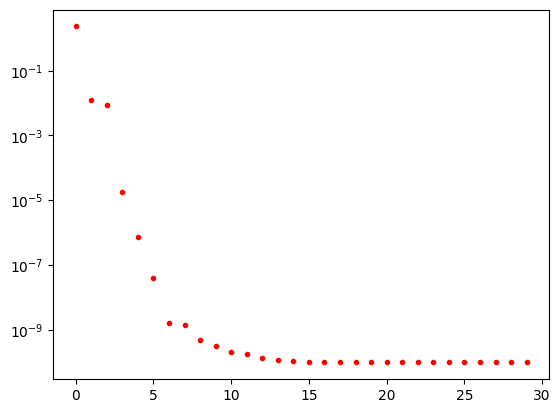

[2.30052789e+00 1.26402901e-02 8.45786220e-03 1.77173396e-05
 7.48889425e-07 4.01967405e-08 1.66363827e-09 1.38279252e-09
 5.07345167e-10 3.18255007e-10 2.03122917e-10 1.78356351e-10
 1.37822600e-10 1.22970949e-10 1.07572368e-10 1.02219305e-10
 1.00183736e-10 1.00064825e-10 1.00003068e-10 1.00000920e-10
 1.00000118e-10 1.00000025e-10 9.99999903e-11 9.99999722e-11
 9.99999670e-11 9.99999658e-11 9.99999591e-11 9.99999393e-11
 9.99999066e-11 9.99998696e-11]
iter 04: dim(V)=12  max H2 error=3.4365e-03 at p=(1.0, -1.0)


In [12]:
result = greedy_parametric_bt(
    param_grid=param_grid,
    A_of_p=A_of_p, B=B, C=C,
    r_loc=3, K=10, tol=5e-3,
    p_start=(0.0, 0.0),
    r_merge_cap= 20  # dimenzija globalne reducirane baze
)


In [13]:
k = 4  

# najgora greedy točka u iteraciji k
p_star = tuple(result["argmax_params"][k-1])

# baze prije i poslije dodavanja te točke (V_list sadrži V0 pa su slicevi ovakvi)
V_before = merge_V_bases(result["V_list"][:k],   r_merge=None)
V_after  = merge_V_bases(result["V_list"][:k+1], r_merge=None)

delta = 0.2
neighbors = [
    p_star,
    (p_star[0] + delta, p_star[1]),
    (p_star[0], p_star[1] + delta),
]

print("k =", k)
print("p* =", p_star)
print("dim(V_before) =", V_before.shape[1], "dim(V_after) =", V_after.shape[1])


k = 4
p* = (1.0, -1.0)
dim(V_before) = 12 dim(V_after) = 12


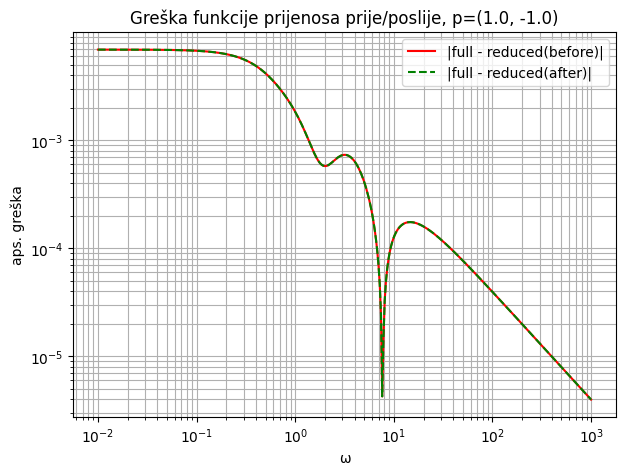

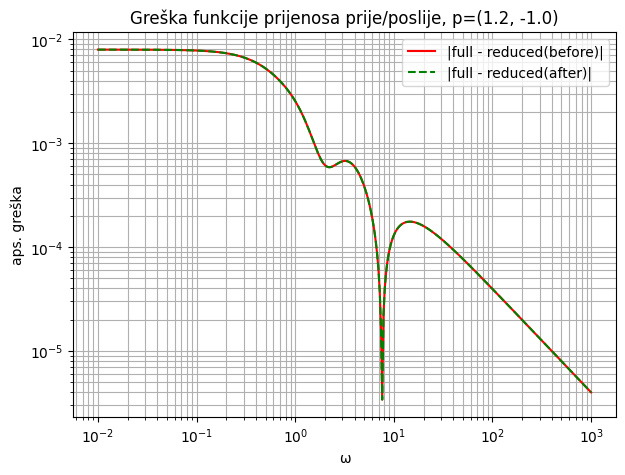

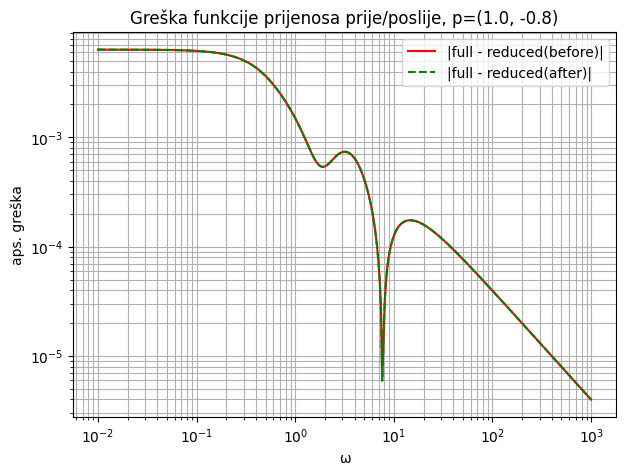

In [14]:
def tf_fun_eval(A, B, C, s):
    n = A.shape[0]
    G = C @ np.linalg.solve(s*np.eye(n) - A, B)
    sigma = npLA.svd(G, compute_uv=False)
    return sigma[0]


def plot_transfer_error_before_after(p, Vb, Va, w):
    Af = A_of_p(*p)
    Ar_b, Br_b, Cr_b = project_model_galerkin(Af, B, C, Vb)
    Ar_a, Br_a, Cr_a = project_model_galerkin(Af, B, C, Va)

    # σ_max transfera (najveca sing vrijednost matrice prijenosa)
    tf_full = np.array([tf_fun_eval(Af, B, C, 1j*omega) for omega in w])
    tf_b    = np.array([tf_fun_eval(Ar_b, Br_b, Cr_b, 1j*omega) for omega in w])
    tf_a    = np.array([tf_fun_eval(Ar_a, Br_a, Cr_a, 1j*omega) for omega in w])

    # apsolutna frekvencijska greška fje prijenosa
    err_b = np.abs(tf_full - tf_b)
    err_a = np.abs(tf_full - tf_a)

    plt.figure(figsize=(7,5))
    plt.loglog(w, err_b, 'r', label="|full - reduced(before)|")
    plt.loglog(w, err_a, 'g--', label="|full - reduced(after)|")
    plt.xlabel("ω")
    plt.ylabel("aps. greška")
    plt.title(f"Greška funkcije prijenosa prije/poslije, p={p}")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

w = np.logspace(-2, 3, 400)

for p in neighbors:
    plot_transfer_error_before_after(p, V_before, V_after, w)


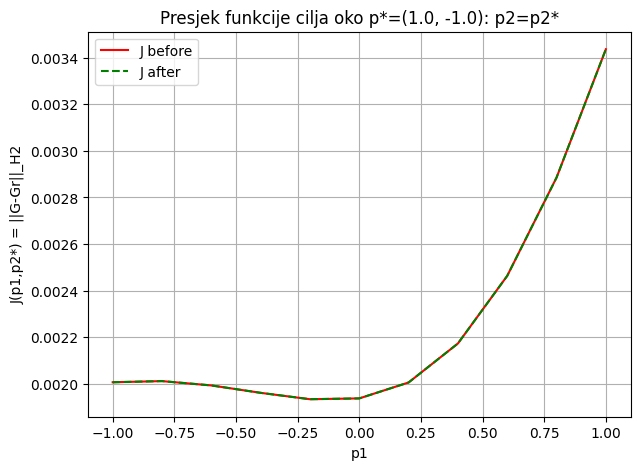

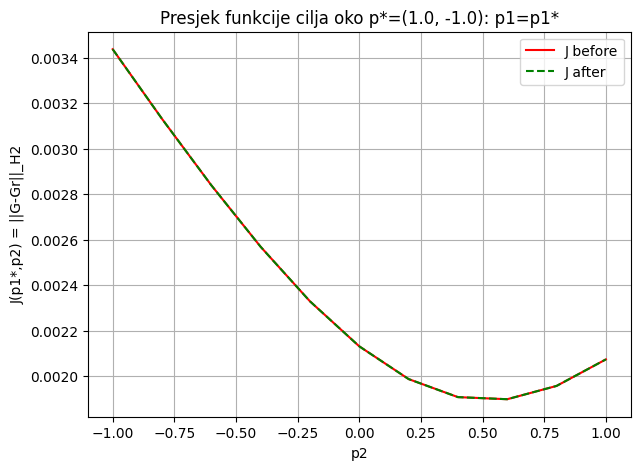

In [15]:
# grid vrijednosti iz iste mreže koju koristi greedy
p1_vals = sorted(set(p[0] for p in param_grid))
p2_vals = sorted(set(p[1] for p in param_grid))

def J_of_p(p1, p2, V):
    Af = A_of_p(p1, p2)
    full = (Af, B, C)
    Ar, Br, Cr = project_model_galerkin(Af, B, C, V)
    return h2_error(full, (Ar, Br, Cr))

p1_star, p2_star = p_star

# presjek po p1 (p2 fiksan)
Jb_p1 = [J_of_p(p1, p2_star, V_before) for p1 in p1_vals]
Ja_p1 = [J_of_p(p1, p2_star, V_after)  for p1 in p1_vals]

plt.figure(figsize=(7,5))
plt.plot(p1_vals, Jb_p1, 'r', label="J before")
plt.plot(p1_vals, Ja_p1, 'g--', label="J after")
plt.xlabel("p1")
plt.ylabel("J(p1,p2*) = ||G-Gr||_H2")
plt.title(f"Presjek funkcije cilja oko p*={p_star}: p2=p2*")
plt.grid(True)
plt.legend()
plt.show()

# presjek po p2 (p1 fiksan)
Jb_p2 = [J_of_p(p1_star, p2, V_before) for p2 in p2_vals]
Ja_p2 = [J_of_p(p1_star, p2, V_after)  for p2 in p2_vals]

plt.figure(figsize=(7,5))
plt.plot(p2_vals, Jb_p2, 'r', label="J before")
plt.plot(p2_vals, Ja_p2, 'g--', label="J after")
plt.xlabel("p2")
plt.ylabel("J(p1*,p2) = ||G-Gr||_H2")
plt.title(f"Presjek funkcije cilja oko p*={p_star}: p1=p1*")
plt.grid(True)
plt.legend()
plt.show()


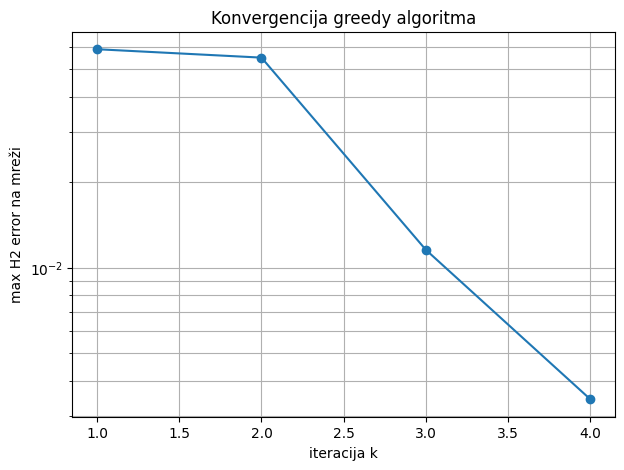

Greedy worst parametri po iteracijama:
iter 01: p = (-1.0, -1.0)
iter 02: p = (-1.0, 1.0)
iter 03: p = (1.0, 1.0)
iter 04: p = (1.0, -1.0)


In [16]:
plt.figure(figsize=(7,5))
plt.semilogy(range(1, len(result["max_errors"])+1), result["max_errors"], marker="o")
plt.xlabel("iteracija k")
plt.ylabel("max H2 error na mreži")
plt.title("Konvergencija greedy algoritma")
plt.grid(True, which="both")
plt.show()

print("Greedy worst parametri po iteracijama:")
for k_i, p in enumerate(result["argmax_params"], 1):
    print(f"iter {k_i:02d}: p = {p}")


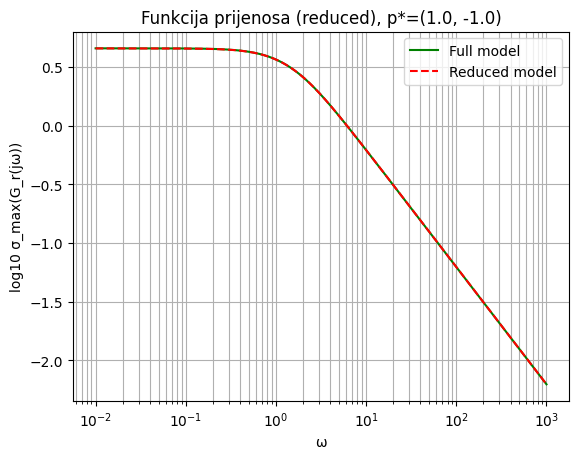

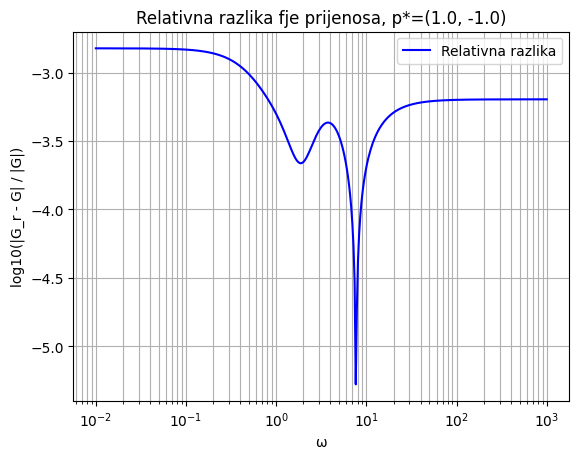

In [17]:
Af = A_of_p(*p_star)

# baza koju usporedujemo (after dodavanja te točke)
V_after = merge_V_bases(result["V_list"][:k+1], r_merge=None)
Ar, Br, Cr = project_model_galerkin(Af, B, C, V_after)

t1 = np.logspace(-2, 3, 400)   # gusca mreza
tfplot1 = np.array([tf_fun_eval(Af, B, C, tt*1j) for tt in t1])
plt.semilogx(t1, np.log10(abs(tfplot1)), 'g-', label='Full model')
plt.title(f"Funkcija prijenosa (full), p*={p_star}")
plt.xlabel("ω")
plt.ylabel("log10 σ_max(G(jω))")
plt.grid(True, which="both")
plt.legend()

t2 = np.logspace(-2, 3, 400)
tfplot2 = np.array([tf_fun_eval(Ar, Br, Cr, tt*1j) for tt in t2])
plt.semilogx(t2, np.log10(abs(tfplot2)), 'r--', label='Reduced model')
plt.title(f"Funkcija prijenosa (reduced), p*={p_star}")
plt.xlabel("ω")
plt.ylabel("log10 σ_max(G_r(jω))")
plt.grid(True, which="both")
plt.legend()
plt.show()

plt.semilogx(t1, np.log10(abs(tfplot2 - tfplot1) / (abs(tfplot1) + 1e-12)),
             'b-', label='Relativna razlika')
plt.title(f"Relativna razlika fje prijenosa, p*={p_star}")
plt.xlabel("ω")
plt.ylabel("log10(|G_r - G| / |G|)")
plt.grid(True, which="both")
plt.legend()
plt.show()


In [18]:
V_final = merge_V_bases(result["V_list"], r_merge=20)

def reduced_model_for_p(p1,p2):
    A = A_of_p(p1,p2)
    return project_model_galerkin(A, B, C, V_final)



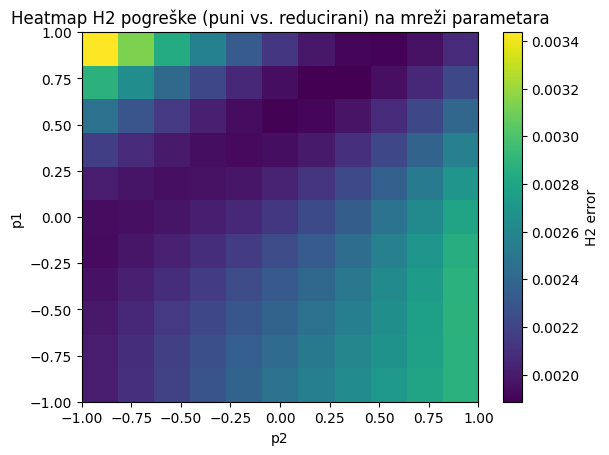

Max H2 error na mreži: 0.003436539920106057
Mean H2 error na mreži: 0.0022887476398258323


In [19]:
errors_map = np.zeros((len(p1_vals), len(p2_vals)))

for i,p1 in enumerate(p1_vals):
    for j,p2 in enumerate(p2_vals):
        Af = A_of_p(p1,p2)
        full = (Af, B, C)
        red = reduced_model_for_p(p1,p2)
        errors_map[i,j] = h2_error(full, red)

plt.figure()
plt.imshow(errors_map, origin='lower', aspect='auto',
           extent=[p2_vals[0], p2_vals[-1], p1_vals[0], p1_vals[-1]])
plt.colorbar(label="H2 error")
plt.xlabel("p2")
plt.ylabel("p1")
plt.title("Heatmap H2 pogreške (puni vs. reducirani) na mreži parametara")
plt.show()

print("Max H2 error na mreži:", errors_map.max())
print("Mean H2 error na mreži:", errors_map.mean())


In [20]:
def compute_error_grid(V):
    err_grid = np.zeros((len(p1_vals), len(p2_vals)))

    for i, p1 in enumerate(p1_vals):
        for j, p2 in enumerate(p2_vals):

            Af = A_of_p(p1, p2)
            full = (Af, B, C)

            Ar, Br, Cr = project_model_galerkin(Af, B, C, V)
            red = (Ar, Br, Cr)

            err_grid[i, j] = h2_error(full, red)

    return err_grid

In [21]:
err_before = compute_error_grid(V_before)
err_after  = compute_error_grid(V_after)


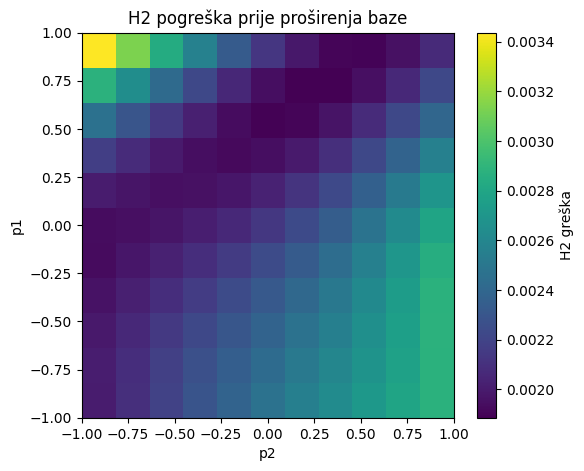

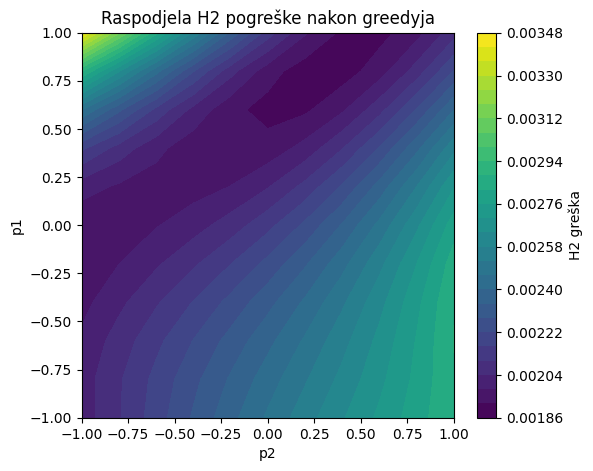

In [22]:
plt.figure(figsize=(6,5))

plt.imshow(err_before,
           extent=[p2_vals[0], p2_vals[-1], p1_vals[0], p1_vals[-1]],
           origin='lower',
           aspect='auto')

plt.colorbar(label="H2 greška")
plt.xlabel("p2")
plt.ylabel("p1")
plt.title("H2 pogreška prije proširenja baze")

plt.show()


plt.figure(figsize=(6,5))

plt.contourf(p2_vals, p1_vals, err_after, levels=30)
plt.colorbar(label="H2 greška")

plt.xlabel("p2")
plt.ylabel("p1")
plt.title("Raspodjela H2 pogreške nakon greedyja")

plt.show()
